In [1]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.types import IntegerType

In [2]:
spark = SparkSession.builder \
        .master('local[*]') \
        .appName('first_spark_application') \
        .getOrCreate() #if there is a active session it will get or create one

In [3]:
# loading data 

health = spark.read.csv('train.csv', header=True, inferSchema=True)

In [4]:
# Indexing categorical data
from pyspark.sql.functions import lit ,when
health = health.withColumn('Vehicle_Age', when(health.Vehicle_Age == '< 1 Year', lit(1)).otherwise(health.Vehicle_Age))
health = health.withColumn('Vehicle_Age', when(health.Vehicle_Age == '1-2 Year', lit(2)).otherwise(health.Vehicle_Age))
health = health.withColumn('Vehicle_Age', when(health.Vehicle_Age == '> 2 Years', lit(3)).otherwise(health.Vehicle_Age))
health = health.withColumn('Vehicle_Age', health['Vehicle_Age'].cast(IntegerType()))



#indexer1 = StringIndexer(inputCol='Vehicle_Age',
#outputCol='Vehicle_Age_idx')

indexer2 = StringIndexer(inputCol='Gender',
outputCol='Gender_idx')

indexer3 = StringIndexer(inputCol='Vehicle_Damage',
outputCol='Vehicle_Damage_idx')


# now we need to combine all the features in a single list
# we are doing this because pyspark.ml what all the features in a list

assembler = VectorAssembler(inputCols=['Age', 'Driving_License', 
                                       'Region_Code', 'Previously_Insured', 
                                       'Annual_Premium', 
                                       'Policy_Sales_Channel', 'Vintage', 
                                        'Gender_idx','Vehicle_Damage_idx'],
                            outputCol='features')

pipeline = Pipeline(stages=[indexer2, indexer3, assembler])

In [5]:
# using pipeline to prepare data for models 
healthe = pipeline.fit(health).transform(health)

In [6]:
healthe.show(2)

+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+----------+------------------+--------------------+
| id|Gender|Age|Driving_License|Region_Code|Previously_Insured|Vehicle_Age|Vehicle_Damage|Annual_Premium|Policy_Sales_Channel|Vintage|Response|Gender_idx|Vehicle_Damage_idx|            features|
+---+------+---+---------------+-----------+------------------+-----------+--------------+--------------+--------------------+-------+--------+----------+------------------+--------------------+
|  1|  Male| 44|              1|       28.0|                 0|          3|           Yes|       40454.0|                26.0|    217|       1|       0.0|               0.0|[44.0,1.0,28.0,0....|
|  2|  Male| 76|              1|        3.0|                 0|          2|            No|       33536.0|                26.0|    183|       0|       0.0|               1.0|[76.0,1.0,3.0,0.0...|
+---+------+---+---------

# preparing data for model fitting

- We are selecting the features column and response column to get that data needed for predictions

- we need to change the output column name to label for the models to work right in spark


In [7]:
# making the column names as pyspark wants
health_ml = healthe.select(['features','Response']).withColumnRenamed('Response', 'label')

In [8]:
health_ml.show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[44.0,1.0,28.0,0....|    1|
|[76.0,1.0,3.0,0.0...|    0|
+--------------------+-----+
only showing top 2 rows



In [9]:
health_ml.groupby('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1| 46710|
|    0|334399|
+-----+------+



As you can see we have more values corrospoding to 0 class, so we need to do something to tackel this problem

In [ ]:
sScaler = StandardScaler(
    withMean=True, withStd=True, inputCol="features", outputCol="features_scc"
        )

In [ ]:
# using standard scaler to scale data 
health_ml = sScaler.fit(health_ml).transform(health_ml)

In [ ]:
health_ml.show(5)

health_ml = health_ml.drop('features').withColumnRenamed('features_scc', 'features')
health_ml.show(5)

In [10]:
# Specify a seed for reproducibility
# we are spliting the data in test train

health_train, health_test = health_ml.randomSplit([0.8, 0.2], seed= 23 )

In [11]:
print(health_train.count(), health_test.count())

305127 75982


## LogisticRegression

In [12]:
from pyspark.ml.classification import LogisticRegression


In [13]:
model = LogisticRegression(featuresCol='features', labelCol='label')

In [14]:
logistic = model.fit(health_train)

### Make predictions on the test set.

In [15]:
predection = logistic.transform(health_test)

In [16]:
predection.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[20.0,1.0,2.0,0.0...|    0|[1.31568048167347...|[0.78846215354341...|       0.0|
|[20.0,1.0,2.0,0.0...|    0|[1.17944877514661...|[0.76484867759371...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



In [17]:
predection.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 9376|
|    0|       0.0|66606|
+-----+----------+-----+



### Evaluate Logistic Regression model.

In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predection))

Test Area Under ROC 0.8164133032668313


### We can obtain the coefficients by using LogisticRegressionModel’s attributes.

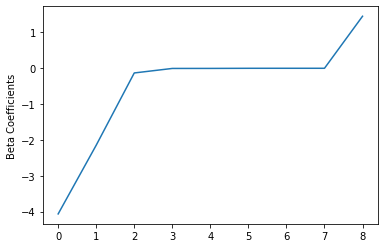

In [19]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(logistic.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

### Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.

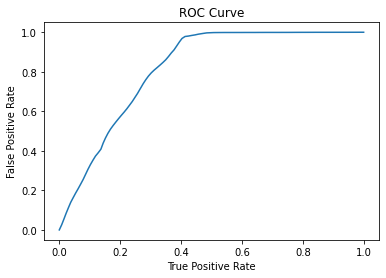

Training set areaUnderROC: 0.8152862073244929


In [20]:
trainingSummary = logistic.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Precision and recall.


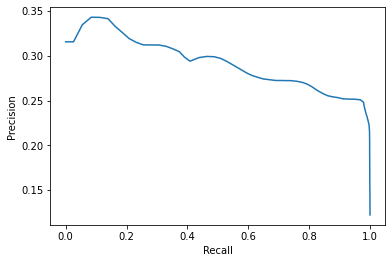

In [21]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Decision Tree 

In [22]:
# Import the Decision Tree Classifier class
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(health_train)

# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(health_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+-------------------------------------+
|label|prediction|probability                          |
+-----+----------+-------------------------------------+
|0    |0.0       |[0.877644390696333,0.122355609303667]|
|0    |0.0       |[0.877644390696333,0.122355609303667]|
|0    |0.0       |[0.877644390696333,0.122355609303667]|
|0    |0.0       |[0.877644390696333,0.122355609303667]|
|0    |0.0       |[0.877644390696333,0.122355609303667]|
+-----+----------+-------------------------------------+
only showing top 5 rows



In [23]:
prediction.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 9376|
|    0|       0.0|66606|
+-----+----------+-----+



In [24]:
tree_model.explainParam

<bound method Params.explainParam of DecisionTreeClassificationModel (uid=DecisionTreeClassifier_99d70b7fbf4d) of depth 0 with 1 nodes>

### Evaluate Decision Tree model


In [25]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5


## Random Forest Classifier

In [26]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(health_train)
predictions = rfModel.transform(health_test)
predictions.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.86768853840389...|
|    0|       0.0|[0.85974499751573...|
|    0|       0.0|[0.86768853840389...|
|    0|       0.0|[0.85974499751573...|
|    0|       0.0|[0.85974499751573...|
|    0|       0.0|[0.86768853840389...|
|    0|       0.0|[0.86768853840389...|
|    0|       0.0|[0.85974499751573...|
|    0|       0.0|[0.86768853840389...|
|    0|       0.0|[0.90125901746398...|
+-----+----------+--------------------+
only showing top 10 rows



### Evaluate Random Forest Classifier

In [27]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8179614550990546


## Gradient-Boosted Tree 

In [28]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(health_train)
predictions = gbtModel.transform(health_test)
predictions.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.90117554543665...|
|    0|       0.0|[0.90117554543665...|
|    0|       0.0|[0.90117554543665...|
|    0|       0.0|[0.90117554543665...|
|    0|       0.0|[0.90117554543665...|
|    0|       0.0|[0.90117554543665...|
|    0|       0.0|[0.90117554543665...|
|    0|       0.0|[0.90117554543665...|
|    0|       0.0|[0.90117554543665...|
|    0|       0.0|[0.92335348753007...|
+-----+----------+--------------------+
only showing top 10 rows



### Evaluate Gradient-Boosted Tree Classifier（It is the best classifier）

In [29]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8502282976612816


### Use explainParams() to print a list of all params and their definitions to understand what params available for tuning.

In [30]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

### 5 Folds CorssValidation with ParamGrid

In [31]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(health_train)
predictions = cvModel.transform(health_test)
evaluator.evaluate(predictions)

0.8527939621941647